In [ ]:
import pandas as pd

df = pd.read_csv("heart_2020_balanced.csv")


In [2]:
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categoric_columns = df.select_dtypes(include=['object']).columns.drop('HeartDisease')

numeric_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer(
    transformers=[
        ("numerical", MinMaxScaler(), numeric_columns),
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categoric_columns),
    ]
)

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop('HeartDisease', axis=1)
y = (df['HeartDisease'] == "Yes").astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [4]:
from xgboost import XGBClassifier

pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
model = Pipeline(steps=[
    ("preprocessing", preprocessing),
    ("clf", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        random_state=42,
        scale_pos_weight=float(pos_weight),
        n_jobs=-1,
    ))
])

model.fit(X_train, y_train)


,steps,"[('preprocessing', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Accuracy: 0.7497
Balanced accuracy: 0.7610
Precision (macro): 0.5978
Recall (macro): 0.7610
F1 (macro): 0.5958
Precision (weighted): 0.9084
Recall (weighted): 0.7497
F1 (weighted): 0.8025
ROC-AUC: 0.8379
Average Precision (PR-AUC): 0.3418

Classification report:
               precision    recall  f1-score   support

           0     0.9726    0.7473    0.8452     43863
           1     0.2230    0.7747    0.3463      4106

    accuracy                         0.7497     47969
   macro avg     0.5978    0.7610    0.5958     47969
weighted avg     0.9084    0.7497    0.8025     47969

Confusion matrix:
 [[32781 11082]
 [  925  3181]]


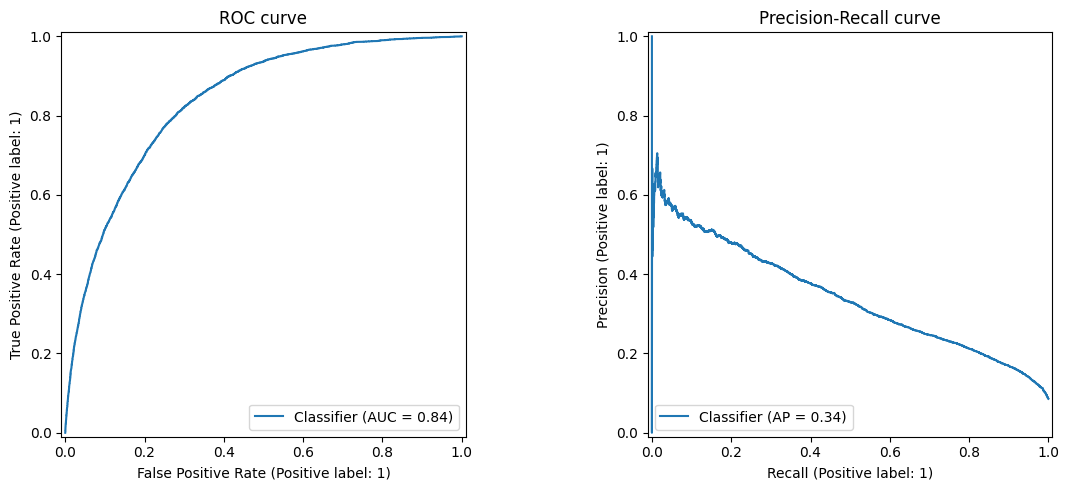

In [5]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
import matplotlib.pyplot as plt

# Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
prec_weighted = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec_weighted = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)
bal_acc = balanced_accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Precision (macro): {prec_macro:.4f}")
print(f"Recall (macro): {rec_macro:.4f}")
print(f"F1 (macro): {f1_macro:.4f}")
print(f"Precision (weighted): {prec_weighted:.4f}")
print(f"Recall (weighted): {rec_weighted:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision (PR-AUC): {ap:.4f}")

print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0])
axes[0].set_title("ROC curve")
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title("Precision-Recall curve")
plt.tight_layout()
plt.show()


Accuracy: 0.7513
Balanced accuracy: 0.7608
Precision (macro): 0.5981
Recall (macro): 0.7608
F1 (macro): 0.5967
Precision (weighted): 0.9083
Recall (weighted): 0.7513
F1 (weighted): 0.8036
ROC-AUC: 0.8385
Average Precision (PR-AUC): 0.3445

Classification report:
               precision    recall  f1-score   support

           0     0.9723    0.7493    0.8464     43863
           1     0.2238    0.7723    0.3471      4106

    accuracy                         0.7513     47969
   macro avg     0.5981    0.7608    0.5967     47969
weighted avg     0.9083    0.7513    0.8036     47969

Confusion matrix:
 [[32867 10996]
 [  935  3171]]


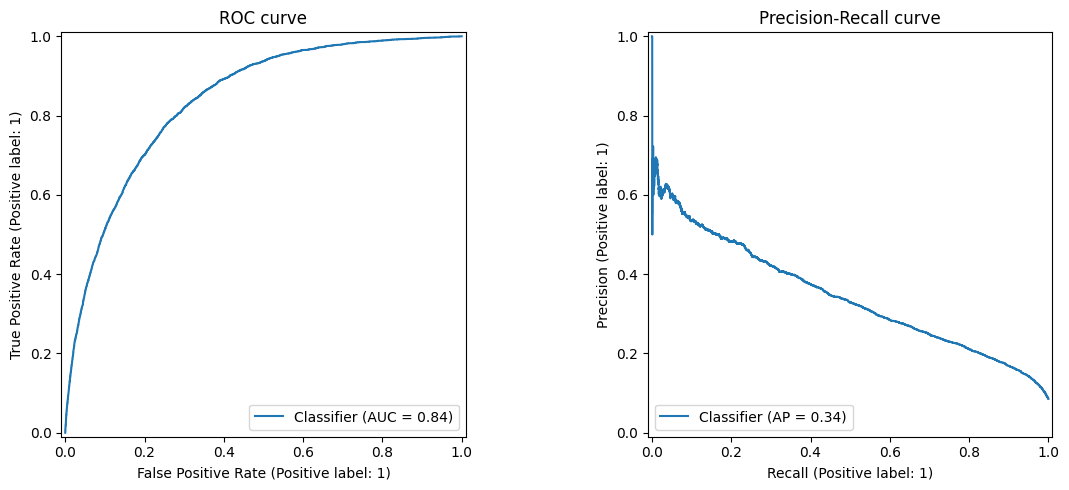